In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_2_multigrid_adaptive'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 1e-4,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.15,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[70,70,50], log_std_init=-1.7),
                verbose = 1,
                target_kl =0.1,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/coarse_grid_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


Using cuda device
seed 1: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f23d0a93dd8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f23d0a93320>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.679    |
| time/              |          |
|    fps             | 137      |
|    iterations      | 1        |
|    time_elapsed    | 18       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 51 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.679     |
| time/                   |           |
|    fps                  | 731       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|  

policy iteration runtime: 35 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.72 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 5        |
|    mean_reward          | 0.717    |
| time/                   |          |
|    fps                  | 774      |
|    iterations           | 1        |
|    time_elapsed         | 3        |
|    total_timesteps      | 2560     |
| train/                  |          |
|    approx_kl            | 0.049085 |
|    clip_fraction        | 0.493    |
|    clip_range           | 0.15     |
|    entropy_loss         | 6.11     |
|    explained_variance   | 0.961    |
|    learning_rate        | 0.0001   |
|    loss                 | -0.0788  |
|    n_updates            | 180      |
|    policy_gradient_loss | -0.0467  |
|    std                  | 0.181    |
|    value_loss           | 0.00163  |
-------

policy iteration runtime: 34 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.745      |
| time/                   |            |
|    fps                  | 779        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05409802 |
|    clip_fraction        | 0.51       |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.46       |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0583    |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.045     |
|    std                  | 0.178      |
|    v

policy iteration runtime: 36 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.771      |
| time/                   |            |
|    fps                  | 765        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07528596 |
|    clip_fraction        | 0.558      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.65       |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0489    |
|    n_updates            | 500        |
|    policy_gradient_loss | -0.0427    |
|    std                  | 0.177      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.777       |
| time/                   |             |
|    fps                  | 778         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.065170564 |
|    clip_fraction        | 0.575       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.96        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.065      |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0417     |
|    std                  | 0.174       |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.791      |
| time/                   |            |
|    fps                  | 781        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06294056 |
|    clip_fraction        | 0.579      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.45       |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0117    |
|    n_updates            | 820        |
|    policy_gradient_loss | -0.0348    |
|    std                  | 0.17       |
|    

policy iteration runtime: 25 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.798      |
| time/                   |            |
|    fps                  | 775        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07259835 |
|    clip_fraction        | 0.587      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.09       |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0453    |
|    n_updates            | 980        |
|    policy_gradient_loss | -0.0353    |
|    std                  | 0.165      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.808       |
| time/                   |             |
|    fps                  | 786         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.068703726 |
|    clip_fraction        | 0.597       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.94        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0173     |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0325     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.814      |
| time/                   |            |
|    fps                  | 796        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07281404 |
|    clip_fraction        | 0.6        |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.56       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0728    |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0275    |
|    std                  | 0.155      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.82        |
| time/                   |             |
|    fps                  | 798         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.091239884 |
|    clip_fraction        | 0.613       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0114     |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0285     |
|    std                  |

policy iteration runtime: 35 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.823      |
| time/                   |            |
|    fps                  | 784        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06918831 |
|    clip_fraction        | 0.619      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.8       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0685    |
|    n_updates            | 1620       |
|    policy_gradient_loss | -0.0257    |
|    std                  | 0.146      |
|    

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f23d0678fd0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f23d0aaad30>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.842     |
| time/                   |           |
|    fps                  | 149       |
|    iterations           | 1         |
|    time_elapsed         | 17        |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0894752 |
|    clip_fraction        | 0.601     |
|    clip_range           | 0.15      |
|    entropy_loss         | 11        |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.00128  |
|    n_updates            | 1680      |
|    policy_gradient_loss | -0.0211   |
|    std                  | 0.146     |
|    value_loss           | 0.000713  |
---------------------------------------
policy iterati

policy iteration runtime: 35 seconds

Total episode rollouts: 47104

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.842      |
| time/                   |            |
|    fps                  | 630        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08148356 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.4       |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0408    |
|    n_updates            | 1840       |
|    policy_gradient_loss | -0.0234    |
|    std                  | 0.143      |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 51200

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.842      |
| time/                   |            |
|    fps                  | 627        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09917094 |
|    clip_fraction        | 0.624      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0733    |
|    n_updates            | 2000       |
|    policy_gradient_loss | -0.0246    |
|    std                  | 0.14       |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 55296

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.842      |
| time/                   |            |
|    fps                  | 624        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07722817 |
|    clip_fraction        | 0.635      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.2       |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0141     |
|    n_updates            | 2160       |
|    policy_gradient_loss | -0.0234    |
|    std                  | 0.138      |
|    value_loss           |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f23d0a7c1d0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f23d0796630>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.851      |
| time/                   |            |
|    fps                  | 118        |
|    iterations           | 1          |
|    time_elapsed         | 21         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09950431 |
|    clip_fraction        | 0.627      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.3       |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0264    |
|    n_updates            | 2200       |
|    policy_gradient_loss | -0.02      |
|    std                  | 0.137      |
|    value_loss           | 0.00105    |
---------------------------------

policy iteration runtime: 37 seconds

Total episode rollouts: 60416

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.851       |
| time/                   |             |
|    fps                  | 352         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.088516854 |
|    clip_fraction        | 0.634       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.6        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0553     |
|    n_updates            | 2360        |
|    policy_gradient_loss | -0.0219     |
|    std                  | 0.135       |
|    va

policy iteration runtime: 36 seconds

Total episode rollouts: 64512

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.852      |
| time/                   |            |
|    fps                  | 351        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10548501 |
|    clip_fraction        | 0.634      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0158    |
|    n_updates            | 2520       |
|    policy_gradient_loss | -0.0176    |
|    std                  | 0.134      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 68608

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.854      |
| time/                   |            |
|    fps                  | 350        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09213556 |
|    clip_fraction        | 0.637      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.3       |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0384     |
|    n_updates            | 2680       |
|    policy_gradient_loss | -0.0192    |
|    std                  | 0.131      |
|    

<IPython.core.display.Javascript object>


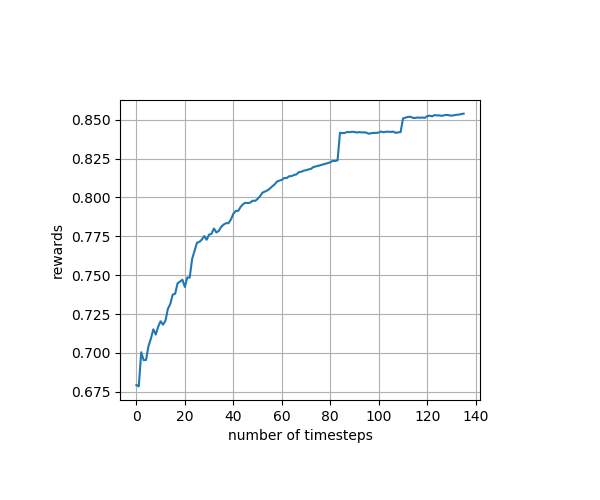

Using cuda device
seed 2: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f23d06939b0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f23d0aaa6d8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.671      |
| time/                   |            |
|    fps                  | 134        |
|    iterations           | 1          |
|    time_elapsed         | 19         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12149398 |
|    clip_fraction        | 0.647      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.4       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00203   |
|    n_updates            | 2720       |
|    policy_gradient_loss | -0.0179    |
|    std                  | 0.131      |
|    value_loss           | 0.0011     |
---------------------------------

policy iteration runtime: 25 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.72 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.723      |
| time/                   |            |
|    fps                  | 720        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.04004362 |
|    clip_fraction        | 0.484      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.07       |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0714    |
|    n_updates            | 160        |
|    policy_gradient_loss | -0.0459    |
|    std                  | 0.181      |
|    v

policy iteration runtime: 25 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.731       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.056324076 |
|    clip_fraction        | 0.51        |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.3         |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0171     |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0445     |
|    std                  | 0.179       |
|    val

policy iteration runtime: 33 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.742       |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.051982533 |
|    clip_fraction        | 0.533       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.6         |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0598     |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0428     |
|    std                  | 0.177       |
|    va

policy iteration runtime: 32 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.761      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06873323 |
|    clip_fraction        | 0.568      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.95       |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0857    |
|    n_updates            | 640        |
|    policy_gradient_loss | -0.0447    |
|    std                  | 0.174      |
|    

policy iteration runtime: 37 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.783      |
| time/                   |            |
|    fps                  | 710        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06620696 |
|    clip_fraction        | 0.586      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.29       |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0788    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.041     |
|    std                  | 0.171      |
|    

policy iteration runtime: 24 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.795      |
| time/                   |            |
|    fps                  | 722        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06673454 |
|    clip_fraction        | 0.602      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.96       |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0222    |
|    n_updates            | 960        |
|    policy_gradient_loss | -0.0358    |
|    std                  | 0.166      |
|    

policy iteration runtime: 30 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.808      |
| time/                   |            |
|    fps                  | 733        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06735216 |
|    clip_fraction        | 0.58       |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.71       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0158    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0275    |
|    std                  | 0.16       |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.814      |
| time/                   |            |
|    fps                  | 718        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07723531 |
|    clip_fraction        | 0.586      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.43       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0435    |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0206    |
|    std                  | 0.156      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.82       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06902157 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.88       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.03      |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.0219    |
|    std                  | 0.152      |
|    

policy iteration runtime: 30 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.827      |
| time/                   |            |
|    fps                  | 724        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06739133 |
|    clip_fraction        | 0.602      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.5       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0816    |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0159    |
|    std                  | 0.148      |
|    

policy iteration runtime: 25 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07672254 |
|    clip_fraction        | 0.61       |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.3       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00139    |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.013     |
|    std                  | 0.143      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.838       |
| time/                   |             |
|    fps                  | 747         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.083745345 |
|    clip_fraction        | 0.616       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.9        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0253     |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0111     |
|    std                  |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f23d0f0feb8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f23d0802198>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.85        |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 1           |
|    time_elapsed         | 19          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.093663886 |
|    clip_fraction        | 0.62        |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.1        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00453    |
|    n_updates            | 1960        |
|    policy_gradient_loss | -0.0142     |
|    std                  | 0.137       |
|    value_loss           | 0.000341    |
------------

policy iteration runtime: 33 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.851      |
| time/                   |            |
|    fps                  | 591        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09447921 |
|    clip_fraction        | 0.632      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.5       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0761    |
|    n_updates            | 2120       |
|    policy_gradient_loss | -0.0144    |
|    std                  | 0.135      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.853       |
| time/                   |             |
|    fps                  | 593         |
|    iterations           | 1           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.080517806 |
|    clip_fraction        | 0.628       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.2        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00387     |
|    n_updates            | 2280        |
|    policy_gradient_loss | -0.0125     |
|    std                  |

policy iteration runtime: 34 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 578        |
|    iterations           | 1          |
|    time_elapsed         | 4          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09689679 |
|    clip_fraction        | 0.642      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.5       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0184     |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.00893   |
|    std                  | 0.129      |
|    value_loss           |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f23d0aaa5c0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f23c44ac208>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.859      |
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 1          |
|    time_elapsed         | 21         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10284491 |
|    clip_fraction        | 0.622      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.6       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.037      |
|    n_updates            | 2480       |
|    policy_gradient_loss | -0.00607   |
|    std                  | 0.128      |
|    value_loss           | 0.000458   |
---------------------------------

policy iteration runtime: 39 seconds

Total episode rollouts: 67584

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.86        |
| time/                   |             |
|    fps                  | 339         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.118440226 |
|    clip_fraction        | 0.645       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14          |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0459     |
|    n_updates            | 2640        |
|    policy_gradient_loss | -0.0107     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 71680

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.86       |
| time/                   |            |
|    fps                  | 346        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10622301 |
|    clip_fraction        | 0.633      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.3       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0429    |
|    n_updates            | 2800       |
|    policy_gradient_loss | -0.00888   |
|    std                  | 0.124      |
|    value_loss           |

policy iteration runtime: 39 seconds

Total episode rollouts: 75776

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.86        |
| time/                   |             |
|    fps                  | 346         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.117998004 |
|    clip_fraction        | 0.636       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.6        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.015       |
|    n_updates            | 2960        |
|    policy_gradient_loss | -0.0078     |
|    std                  | 0.123       |
|    va

<IPython.core.display.Javascript object>


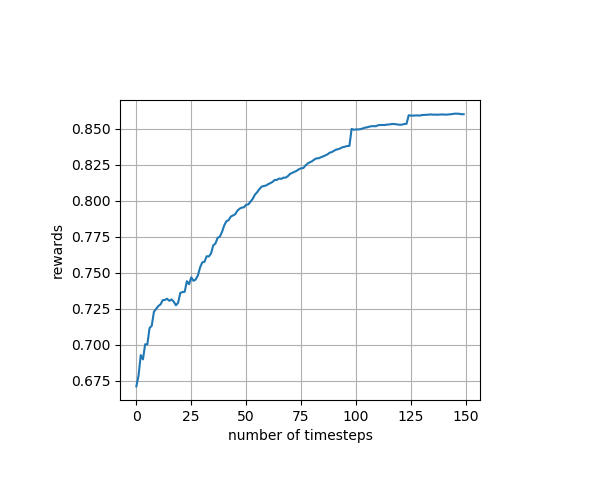

Using cuda device
seed 3: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f23d0c2a080> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f236c0e0cf8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.68       |
| time/                   |            |
|    fps                  | 109        |
|    iterations           | 1          |
|    time_elapsed         | 23         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11598698 |
|    clip_fraction        | 0.643      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.7       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.078     |
|    n_updates            | 3000       |
|    policy_gradient_loss | -0.00809   |
|    std                  | 0.122      |
|    value_loss           | 0.000569   |
---------------------------------

policy iteration runtime: 31 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.727       |
| time/                   |             |
|    fps                  | 799         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.033490755 |
|    clip_fraction        | 0.483       |
|    clip_range           | 0.15        |
|    entropy_loss         | 5.88        |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0773     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0452     |
|    std                  | 

policy iteration runtime: 35 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.745      |
| time/                   |            |
|    fps                  | 806        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.04330797 |
|    clip_fraction        | 0.526      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.18       |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0416    |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0437    |
|    std                  | 0.18       |
|    v

policy iteration runtime: 35 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.758       |
| time/                   |             |
|    fps                  | 791         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.062502824 |
|    clip_fraction        | 0.56        |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.49        |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0129      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0442     |
|    std                  | 0.178       |
|    va

policy iteration runtime: 35 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.772       |
| time/                   |             |
|    fps                  | 740         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.061955355 |
|    clip_fraction        | 0.577       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.97        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0639     |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0416     |
|    std                  |

policy iteration runtime: 33 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.781       |
| time/                   |             |
|    fps                  | 776         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.078381255 |
|    clip_fraction        | 0.584       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.41        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0373     |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0344     |
|    std                  |

policy iteration runtime: 35 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.793       |
| time/                   |             |
|    fps                  | 792         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.085904405 |
|    clip_fraction        | 0.579       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.06        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.046      |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0326     |
|    std                  |

policy iteration runtime: 35 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.805      |
| time/                   |            |
|    fps                  | 789        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07088951 |
|    clip_fraction        | 0.604      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.6        |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0147    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0278    |
|    std                  | 0.162      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.814      |
| time/                   |            |
|    fps                  | 785        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08384001 |
|    clip_fraction        | 0.609      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.23       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0705    |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0247    |
|    std                  | 0.157      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.819     |
| time/                   |           |
|    fps                  | 783       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0770528 |
|    clip_fraction        | 0.614     |
|    clip_range           | 0.15      |
|    entropy_loss         | 9.98      |
|    explained_variance   | 0.987     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0441   |
|    n_updates            | 1440      |
|    policy_gradient_loss | -0.0225   |
|    std                  | 0.152     |
|    value_loss          

policy iteration runtime: 35 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.824      |
| time/                   |            |
|    fps                  | 753        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07960223 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.5       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0364    |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0163    |
|    std                  | 0.149      |
|    

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f236c0e5278> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f236c0b6da0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.837       |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 1           |
|    time_elapsed         | 19          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.088500746 |
|    clip_fraction        | 0.606       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.6        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0139     |
|    n_updates            | 1680        |
|    policy_gradient_loss | -0.0216     |
|    std                  | 0.148       |
|    value_loss           | 0.000652    |
------------

policy iteration runtime: 35 seconds

Total episode rollouts: 47104

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.839      |
| time/                   |            |
|    fps                  | 644        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07540858 |
|    clip_fraction        | 0.599      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.1       |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0624    |
|    n_updates            | 1840       |
|    policy_gradient_loss | -0.0162    |
|    std                  | 0.145      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 51200

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.84        |
| time/                   |             |
|    fps                  | 647         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.087693654 |
|    clip_fraction        | 0.607       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.6        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0531     |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.0167     |
|    std                  | 0.142       |
|    va

policy iteration runtime: 35 seconds

Total episode rollouts: 55296

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 5        |
|    mean_reward          | 0.841    |
| time/                   |          |
|    fps                  | 630      |
|    iterations           | 1        |
|    time_elapsed         | 4        |
|    total_timesteps      | 2560     |
| train/                  |          |
|    approx_kl            | 0.084465 |
|    clip_fraction        | 0.622    |
|    clip_range           | 0.15     |
|    entropy_loss         | 11.9     |
|    explained_variance   | 0.986    |
|    learning_rate        | 0.0001   |
|    loss                 | -0.0689  |
|    n_updates            | 2160     |
|    policy_gradient_loss | -0.0205  |
|    std                  | 0.141    |
|    value_loss           | 0.000865 |
----------------------------

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f236c065d30> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f23643b10b8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 1          |
|    time_elapsed         | 22         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11911945 |
|    clip_fraction        | 0.628      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0249     |
|    n_updates            | 2200       |
|    policy_gradient_loss | -0.0177    |
|    std                  | 0.14       |
|    value_loss           | 0.000862   |
---------------------------------

policy iteration runtime: 39 seconds

Total episode rollouts: 60416

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.85       |
| time/                   |            |
|    fps                  | 346        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11664897 |
|    clip_fraction        | 0.631      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.3       |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0241    |
|    n_updates            | 2360       |
|    policy_gradient_loss | -0.0191    |
|    std                  | 0.138      |
|    value_loss           |

policy iteration runtime: 39 seconds

Total episode rollouts: 64512

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.85       |
| time/                   |            |
|    fps                  | 341        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09581495 |
|    clip_fraction        | 0.637      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.7       |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0429    |
|    n_updates            | 2520       |
|    policy_gradient_loss | -0.0188    |
|    std                  | 0.135      |
|    value_loss           |

policy iteration runtime: 40 seconds

Total episode rollouts: 68608

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.85        |
| time/                   |             |
|    fps                  | 342         |
|    iterations           | 1           |
|    time_elapsed         | 7           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.114243366 |
|    clip_fraction        | 0.64        |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.8        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0161     |
|    n_updates            | 2680        |
|    policy_gradient_loss | -0.0164     |
|    std                  | 0.135       |
|    va

<IPython.core.display.Javascript object>


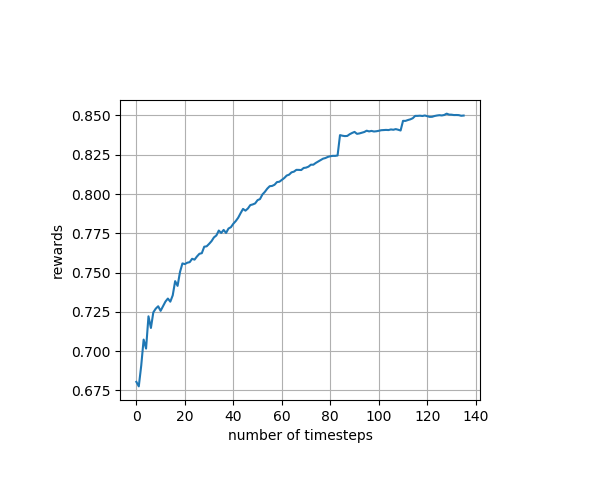

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=25,
                                grid_fidelity_factor_array =[0.25, 0.5, 1.0],
                                episode_limit_array=[50000, 50000, 50000], 
                                log_dir=log_dir,
                                seed=seed)